<a href="https://colab.research.google.com/github/alee-kolachi/FashionMNIST_CNN/blob/main/computer_vision_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [53]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [54]:
len(train_data), len(test_data)

(60000, 10000)

In [55]:
image, label = train_data[0]
label

9

In [56]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [57]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [58]:
image.shape

torch.Size([1, 28, 28])

# Visualizing our Data

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

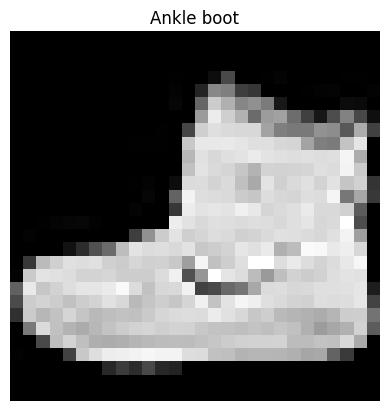

In [59]:
import matplotlib.pyplot as plt

image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

In [60]:
torch.manual_seed(42)

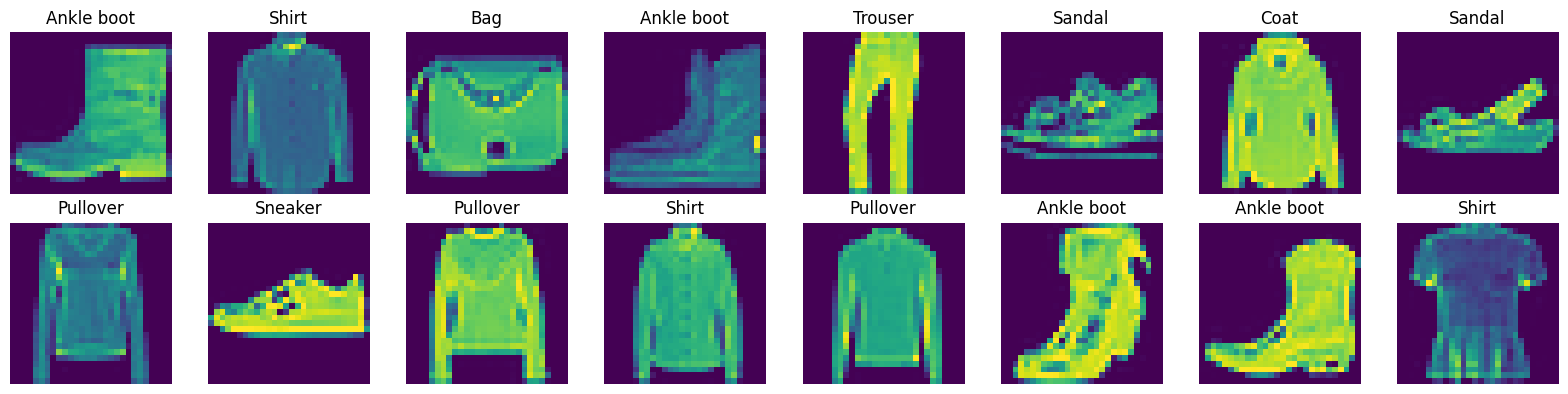

In [61]:
fig = plt.figure(figsize=(16, 4))  # much wider than tall
rows, columns = 2, 8
for i in range(1, rows * columns + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(train_data[random_idx][0].squeeze())
    plt.title(class_names[train_data[random_idx][1]])
    plt.axis("off")
plt.tight_layout()


In [62]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [63]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_size:int,
               hidden_units:int,
               output_size:int):
    super().__init__()
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_size, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_size)
    )

  def forward(self, x):
    return self.model(x)

In [64]:
torch.manual_seed(42)

model = FashionMNISTModelV0(
    input_size=28*28,
    hidden_units=10,
    output_size=len(class_names)
)
model

FashionMNISTModelV0(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [65]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [66]:
from timeit import default_timer as timer

def print_train_timer(
    start: float,
    end: float,
    device: torch.device = None
  ):

  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")

In [67]:
start_time = timer()

flatten = nn.Flatten()
rando_x = flatten(torch.rand([1,1,280,280])).squeeze()
rando_y = flatten(torch.rand([1,1,280,280])).squeeze()

dot_product = torch.dot(rando_x, rando_y)

end_time = timer()


print_train_timer(start_time, end_time)

Train time on None: 0.004 seconds


In [69]:
from tqdm.auto import tqdm
import torch

torch.manual_seed(42)

train_time_start_on_cpu = timer()
epochs = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # accumulate scalar float
        train_loss += loss.item()

        preds = y_pred.argmax(dim=1)
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at batch {batch*len(X)} / {len(train_dataloader.dataset)} samples.")

    # average training loss over batches
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_correct / train_total

    # ---- Eval ----
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    # use inference_mode for speed/safety, but accumulate .item() from each loss
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_pred = model(X_test)
            loss_val = loss_fn(test_pred, y_test)

            # convert to Python float before accumulating
            test_loss += loss_val.item()

            preds = test_pred.argmax(dim=1)
            test_correct += (preds == y_test).sum().item()
            test_total += y_test.size(0)

    test_loss = test_loss / len(test_dataloader)
    test_acc = test_correct / test_total

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.4f}")

train_time_end_on_cpu = timer()

total_train_time_model_cpu = print_train_timer(start=train_time_start_on_cpu,
                                               end=train_time_end_on_cpu)


  0%|          | 0/3 [00:00<?, ?it/s]

Looked at batch 0 / 60000 samples.
Looked at batch 12800 / 60000 samples.
Looked at batch 25600 / 60000 samples.
Looked at batch 38400 / 60000 samples.
Looked at batch 51200 / 60000 samples.
Epoch 1/3
  Train Loss: 0.4764, Train Acc: 0.8333
  Test  Loss: 0.4825, Test  Acc: 0.8298
Looked at batch 0 / 60000 samples.
Looked at batch 12800 / 60000 samples.
Looked at batch 25600 / 60000 samples.
Looked at batch 38400 / 60000 samples.
Looked at batch 51200 / 60000 samples.
Epoch 2/3
  Train Loss: 0.4556, Train Acc: 0.8405
  Test  Loss: 0.4725, Test  Acc: 0.8361
Looked at batch 0 / 60000 samples.
Looked at batch 12800 / 60000 samples.
Looked at batch 25600 / 60000 samples.
Looked at batch 38400 / 60000 samples.
Looked at batch 51200 / 60000 samples.
Epoch 3/3
  Train Loss: 0.4436, Train Acc: 0.8445
  Test  Loss: 0.4714, Test  Acc: 0.8356
Train time on None: 34.445 seconds


# CNN TINY VGG MODEL

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm


In [71]:
from torchvision import datasets
import torchvision

fashion_train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

fashion_test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [72]:
train_size = int(0.9 * len(fashion_train_dataset))
val_size = len(fashion_train_dataset) - train_size
fashion_train, fashion_val = random_split(fashion_train_dataset, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(fashion_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(fashion_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(fashion_test_dataset, batch_size=batch_size, shuffle=False)

len(fashion_train), len(fashion_val), len(fashion_test_dataset)

(54000, 6000, 10000)

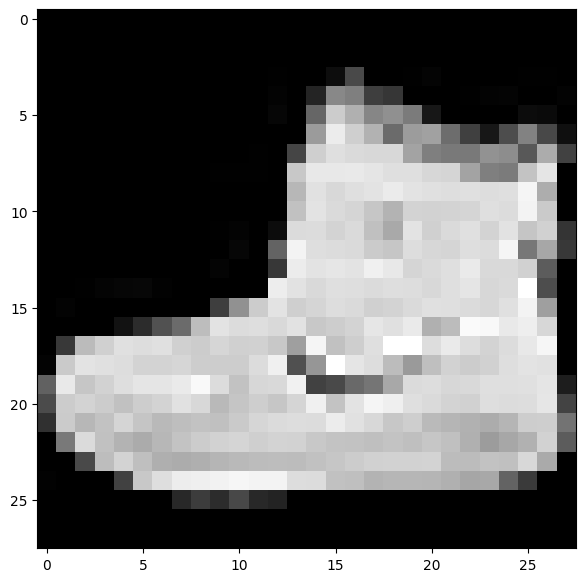

In [73]:
import matplotlib.pyplot as plt

img, label = fashion_train_dataset[0]
fig = plt.figure(figsize=(7,7))

plt.imshow(img.squeeze(), cmap="gray")

In [74]:
class_names = fashion_train_dataset.classes

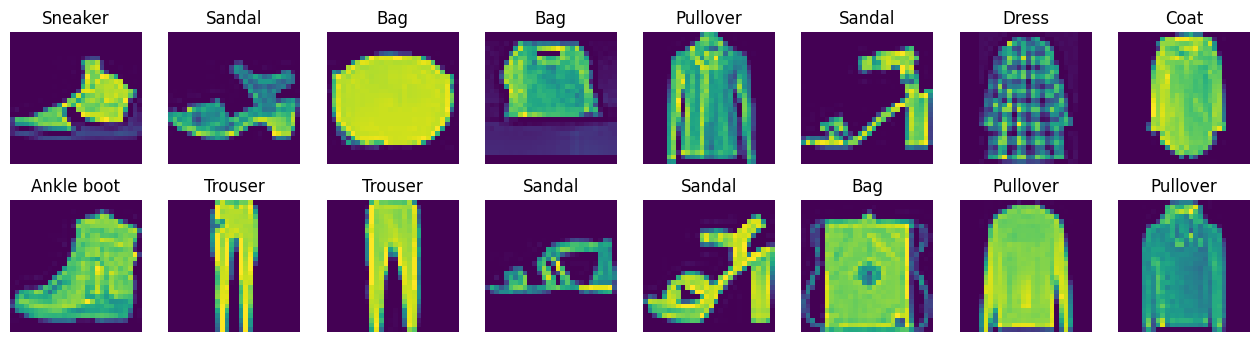

In [75]:


fig = plt.figure(figsize=(16, 4))
rows, columns = 2, 8
for i in range(1, rows * columns + 1):
  random_idx = torch.randint(0, len(fashion_train_dataset), size=[1]).item()
  ax = fig.add_subplot(rows, columns, i)
  plt.imshow(fashion_train_dataset[random_idx][0].squeeze())
  plt.title(class_names[fashion_train_dataset[random_idx][1]])
  plt.axis("off")

In [76]:
class FashionMISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.cnn_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # 28 -> 14
        )
        self.cnn_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # 14 -> 7
        )
        self.head_conv = nn.Conv2d(in_channels=hidden_units, out_channels=10, kernel_size=1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=10*7*7, out_features=10)
        )

    def forward(self, x):
        x = self.cnn_block_1(x)
        x = self.cnn_block_2(x)
        x = self.head_conv(x)
        x = self.classifier(x)
        return x


In [77]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(dataloader, leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total


In [78]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = FashionMISTModelV1(input_shape=1, hidden_units=32, output_shape=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 5
for epoch in range(1, epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch}/{epochs}")
    print(f"  Train loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f}, acc: {val_acc:.4f}")


Epoch 1/5
  Train loss: 0.6593, acc: 0.7591
  Val   loss: 0.4262, acc: 0.8360


Epoch 2/5
  Train loss: 0.3964, acc: 0.8585
  Val   loss: 0.3266, acc: 0.8850


Epoch 3/5
  Train loss: 0.3361, acc: 0.8796
  Val   loss: 0.2950, acc: 0.8927


Epoch 4/5
  Train loss: 0.3025, acc: 0.8921
  Val   loss: 0.2795, acc: 0.9018


Epoch 5/5
  Train loss: 0.2732, acc: 0.9016
  Val   loss: 0.2545, acc: 0.9070


In [79]:
test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Test loss: 0.2897, Test accuracy: 0.8975


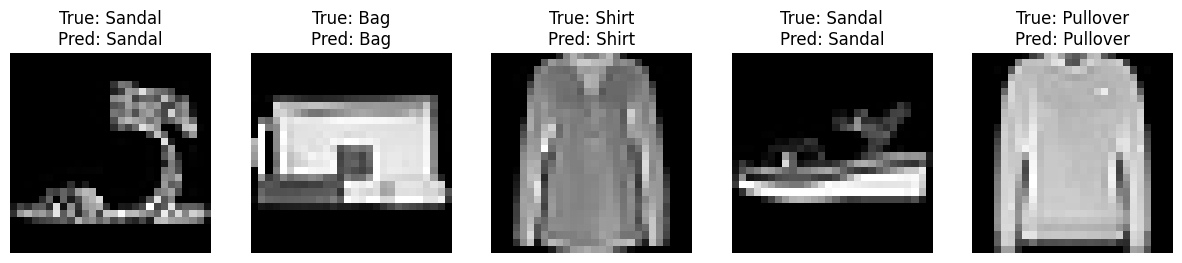

In [81]:
import matplotlib.pyplot as plt
import random

# Set model to eval
model.eval()

# Pick N random images from the test dataset
N = 5
indices = random.sample(range(len(fashion_test_dataset)), N)
fig, axes = plt.subplots(1, N, figsize=(15, 3))

for i, idx in enumerate(indices):
    image, label = fashion_test_dataset[idx]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred = output.argmax(dim=1).item()

    # Plot image
    axes[i].imshow(image.squeeze(), cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}")
plt.show()
